# RBE/CS549 Fall 2022: Computer Vision
## Homework 0: Alohomora

Author(s): 
Prof. Nitin J. Sanket (nsanket@wpi.edu), Lening Li (lli4@wpi.edu), Gejji, Vaishnavi Vivek (vgejji@wpi.edu)

Robotics Engineering Department,

Worcester Polytechnic Institute

Code adapted from CMSC733 at the University of Maryland, College Park.


## Phase 1




### Get the BSDS500 dataset

In [53]:
%matplotlib inline

In [54]:
!wget https://raw.githubusercontent.com/leelening/rbe549/main/hw0/BSDS500.tar.xz
!tar -xvf BSDS500.tar.xz
!mv BSDS500/ /content/data/

--2023-01-19 03:11:20--  https://raw.githubusercontent.com/leelening/rbe549/main/hw0/BSDS500.tar.xz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 812060 (793K) [application/octet-stream]
Saving to: ‘BSDS500.tar.xz.2’

BSDS500.tar.xz.2    100%[===================>] 793.03K  --.-KB/s    in 0.04s   

2023-01-19 03:11:20 (17.5 MB/s) - ‘BSDS500.tar.xz.2’ saved [812060/812060]

BSDS500/
BSDS500/CannyBaseline/
BSDS500/CannyBaseline/1.png
BSDS500/CannyBaseline/10.png
BSDS500/CannyBaseline/2.png
BSDS500/CannyBaseline/3.png
BSDS500/CannyBaseline/4.png
BSDS500/CannyBaseline/5.png
BSDS500/CannyBaseline/6.png
BSDS500/CannyBaseline/7.png
BSDS500/CannyBaseline/8.png
BSDS500/CannyBaseline/9.png
BSDS500/GroundTruth/
BSDS500/GroundTruth/1.png
BSDS500/GroundTruth/10.png
BSDS

In [55]:
import cv2

image = cv2.imread("/content/data/BSDS500/Images/2.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

canny = cv2.imread("/content/data/BSDS500/CannyBaseline/2.png")
cannyBaseline = cv2.cvtColor(canny, cv2.COLOR_BGR2GRAY)

sobel = cv2.imread("/content/data/BSDS500/SobelBaseline/2.png")
sobelBaseline = cv2.cvtColor(sobel, cv2.COLOR_BGR2GRAY)


In [56]:
!wget https://raw.githubusercontent.com/leelening/rbe549/main/hw0/TxtFiles.tar.xz
!tar -xvf TxtFiles.tar.xz
!mv TxtFiles/ /content/data/

--2023-01-19 03:11:28--  https://raw.githubusercontent.com/leelening/rbe549/main/hw0/TxtFiles.tar.xz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55376 (54K) [application/octet-stream]
Saving to: ‘TxtFiles.tar.xz.2’

TxtFiles.tar.xz.2   100%[===================>]  54.08K  --.-KB/s    in 0.01s   

2023-01-19 03:11:28 (4.61 MB/s) - ‘TxtFiles.tar.xz.2’ saved [55376/55376]

TxtFiles/
TxtFiles/DirNamesTest.txt
TxtFiles/DirNamesTrain.txt
TxtFiles/LabelsTest.txt
TxtFiles/LabelsTrain.txt
mv: cannot move 'TxtFiles/' to '/content/data/TxtFiles': Directory not empty


In [57]:
images_folder = "/content/data/BSDS500/images"

results_folder = "./Results/"
if not os.path.exists(results_folder):
  os.mkdir("Results")


In [58]:
import numpy as np
from typing import List, Tuple
from numpy import sqrt, pi, reshape, sin, cos
import matplotlib.pyplot as plt
import cv2
from google.colab import files
from sklearn.cluster import KMeans


1. Generate Difference of Gaussian Filter Bank: (DoG)
2. Display all the filters in this filter bank and save image as DoG.png,
3. use command "cv2.imwrite(...)"

In [82]:
#2D Gaussian
def Gauss2D(size, sigma):
    shape = (size,size)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g1 = np.exp(-0.5 * ((x**2 / sigma**2) + (y ** 2 / sigma**2)))
    g2 = (2 * np.pi * sigma* sigma)
    return g1/g2

#Sobel Filter
sobelfilter = np.array ([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

#DoG Filter
def get_DoG(scale_select, orientations, size):
  DoGs = []
  scale_select = [1, 1.5]
  orientations = 16
  size = 5
  filter_shape = (size, size)
  bound = (size - 1) / 2
  spread = np.linspace(-bound, bound, size)
  x, y = np.meshgrid(spread, spread)
  center = (int(size/2), int(size/2))

  for sigma in scale_select:
      g = Gauss2D(size,sigma)
      g_2d = reshape(g, filter_shape)
      g_convolved = cv2.filter2D(g_2d,-1, sobelfilter)
      
      for i in range(orientations):
          angle = i * 360 / orientations
          rot = cv2.getRotationMatrix2D(center, angle, scale = 1)
          rotDoG = cv2.warpAffine(src=g_convolved, M=rot, dsize=filter_shape)
          DoGs.append(rotDoG)
      return DoGs

DoGs = get_DoG([1, 1.5], 16, 7)


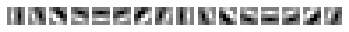

In [85]:
for i in range(len(DoGs)):
    plt.subplot(2,16,i+1)
    plt.axis('off')
    plt.imshow(DoGs[i], cmap = 'gray')
    plt.savefig("DoG.png")


1. Generate Leung-Malik Filter Bank: (LM)
2. Display all the filters in this filter bank and save image as LM.png,
3. use command "cv2.imwrite(...)"


In [63]:
#1D Gaussian for LM
def Gauss1D(sigma, mean, x, ord):
  x = np.array(x)
  x_ = x - mean
  g1 = (1/np.sqrt(2*np.pi * sigma**2))*(np.exp((-1*x_*x_)/(2 * sigma**2)))
  if ord == 0:
    g = g1
    return g
  elif ord == 1:
    g = -g1*((x_)/(sigma**2))
    return g
  else:
    g = g1*(((x_*x_) - sigma**2)/(sigma**4))
    return g

#2D Gaussian for LM
def Gauss2DLM(size, sigma):
    sigma_y = sigma
    sigma_x = 3 * sigma
    shape = (size,size)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    # g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    g1 = np.exp(-0.5 * ((x**2 / sigma_x**2) + (y ** 2 / sigma_y**2)))
    g2 = (2 * np.pi * sigma_x* sigma_y)
    return g1/g2

#LoG 
def log2d(size, sigma):
    shape = (size,size)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    p = (1/np.sqrt(2*np.pi*sigma**2))*np.exp( -(x*x + y*y) / (2*sigma**2) )
    q = p*((x*x + y*y) - sigma**2)/(sigma**4)
    return q

def makefilter(sigma, phasex, phasey, pts, sup):
    gx = Gauss1D(3*sigma, 0, pts[0,...], phasex)
    gy = Gauss1D(sigma,   0, pts[1,...], phasey)
    image = gx*gy
    image = np.reshape(image,(sup,sup))
    return image

def get_LM(scale: List, size, norient):
  
    size     = 49
    scalex  = np.sqrt(2) * np.array([1,2,3])
    norient = 6
    nrotinv = 12
    F = []
    nbar  = len(scalex)*norient
    nedge = len(scalex)*norient
    nf    = nbar+nedge+nrotinv
    F     = np.zeros([size,size,nf])
    hsize  = (size - 1)/2

    x = [np.arange(-hsize,hsize+1)]
    y = [np.arange(-hsize,hsize+1)]

    [x,y] = np.meshgrid(x,y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)
    
    count = 0
    for scale in range(len(scalex)):
        for orient in range(norient):
            angle = (np.pi * orient)/norient
            c = np.cos(angle)
            s = np.sin(angle)
            rotpts = [[c+0,-s+0],[s+0,c+0]]
            rotpts = np.array(rotpts)
            rotpts = np.dot(rotpts,orgpts)
            F[:,:,count] = makefilter(scalex[scale], 0, 1, rotpts, size)
            F[:,:,count+nedge] = makefilter(scalex[scale], 0, 2, rotpts, size)
            count = count + 1
            
    count = nbar+nedge
    scales = np.sqrt(2) * np.array([1,2,3,4])
    
    for i in range(len(scales)):
        F[:,:,count]   = Gauss2D(size, scales[i])
        count = count + 1
        
    for i in range(len(scales)):
        F[:,:,count] = log2d(size, scales[i])
        count = count + 1
        
    for i in range(len(scales)):
        F[:,:,count] = log2d(size, 3*scales[i])
        count = count + 1
    
    return F

##source https://www.robots.ox.ac.uk/~vgg/research/texclass/code/makeLMfilters.m ####

In [64]:
lmsscales = [1,1.414,2]
lmlscales = [1.414, 2, 2.828, 4]
LMS_filters = get_LM(lmsscales, 48, 6)
LML_filters = get_LM(lmlscales, 48, 6)

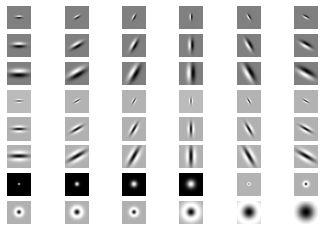

In [73]:
for i in range(48):
    plt.subplot(8,6,i+1)
    plt.axis('off')
    plt.imshow(LML_filters[:,:,i], cmap = 'gray')
    plt.savefig("LM.png")

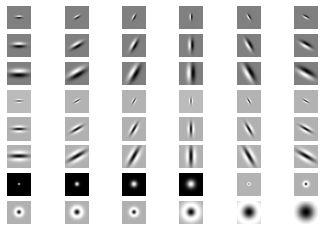

In [71]:
for i in range(48):
    plt.subplot(8,6,i+1)
    plt.axis('off')
    plt.imshow(LML_filters[:,:,i], cmap = 'gray')


1. Generate Gabor Filter Bank: (Gabor)
2. Display all the filters in this filter bank and save image as Gabor.png,
3. use command "cv2.imwrite(...)"


In [142]:
def get_Gabor(size):
  def gabor(llambda, theta, psi, sigma, gamma):
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    nstds = 3  # Number of standard deviation sigma
    xmax = 23   #max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
    xmax = np.ceil(max(1, xmax))
    ymax = 23 #max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
    ymax = np.ceil(max(1, ymax))
    xmin = -xmax
    ymin = -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))

    x_dash = x * np.cos(theta) + y * np.sin(theta)
    y_dash = -x * np.sin(theta) + y * np.cos(theta)

    gab = np.exp(-.5 * (x_dash ** 2 / sigma_x ** 2 + y_dash ** 2 / sigma_y ** 2)) * np.cos(2 * np.pi / llambda * x_dash + psi)

    gab -= np.ones(gab.shape)*np.min(gab)
    gab /= np.max(gab)
    return gab
  return gab
### source   https://en.wikipedia.org/wiki/Gabor_filter    ######

In [135]:
gamma = 1
scale_select = [3, 6, 13, 28, 58]
orientations = 8
llambda = 15
psi = 15
Gabor = []

for sigma in scale_select:
    for i in range(orientations):
        theta = i * np.pi / orientations
        gab = gabor(llambda, theta, psi, sigma, gamma)
        Gabor.append(gab)

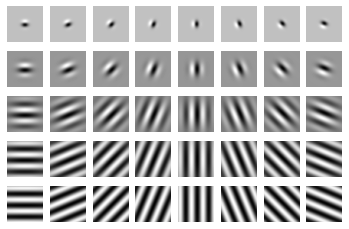

In [136]:
import matplotlib.pyplot as plt

for i in range(len(Gabor)):
    plt.subplot(5,8,i+1)
    plt.axis('off')
    plt.imshow(Gabor[i], cmap = 'gray')
    plt.savefig("Gabor.png")
    


1. Generate Half-disk masks
2. Display all the Half-disk masks and save image as HDMasks.png,
3. use command "cv2.imwrite(...)"

In [90]:
def get_HD(sizes: List[int], angles: int):
    half_disks = []
    for size in sizes:
        bound = (size - 1) / 2
        spread = np.linspace(-bound, bound, size)
        x, y = np.meshgrid(spread, spread)
        pts = [x.flatten(), y.flatten()]
        radius = size / 2

        for i in range(angles):
            angle = (2 * np.pi * i)/angles
            rot = np.array([[np.cos(angle),-np.sin(angle)],[np.sin(angle), np.cos(angle)]])
            rot_pts = np.dot(rot, pts)

            x, y = rot_pts[0], rot_pts[1]

            cond1 = (x ** 2 + y ** 2) < radius ** 2
            cond2 = y > 0
            mask = np.logical_and(cond1, cond2)
            mask = mask.reshape(size, size)
            mask = mask.astype(np.uint8)

            
            half_disks.append(mask)

    return half_disks

half_disks = get_HD([7],8)

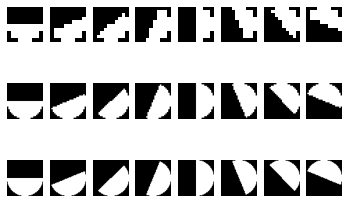

In [91]:

import matplotlib.pyplot as plt

masks = get_HD([10, 26, 50], 16)

left_masks = []

left_masks.extend([*masks[0:8], *masks[16:24], *masks[32:40]])

for i in range(len(left_masks)):
  plt.subplot(3,8,i+1)
  plt.axis('off')
  plt.imshow(left_masks[i], cmap='gray')
  

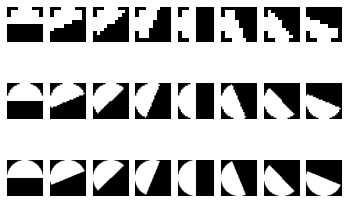

In [92]:
import matplotlib.pyplot as plt

masks = get_HD([10, 26, 50], 16)

right_masks = []

right_masks.extend([*masks[8:16], *masks[24:32], *masks[40:48]])

for i in range(len(right_masks)):
  plt.subplot(3,8,i+1)
  plt.axis('off')
  plt.imshow(right_masks[i], cmap='gray')


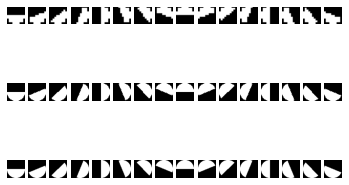

In [93]:
import matplotlib.pyplot as plt

masks = get_HD([10, 26, 50], 16)

for i in range(len(masks)):
    plt.subplot(3, 16, i + 1)
    plt.axis('off')
    plt.imshow(masks[i], cmap='gray')
    plt.savefig("HDMasks.png")
   


1. Generate Texton Map
2. Filter image using oriented gaussian filter bank


1. Create function to add all filters
2. Pass all images through this function to get fully filtered images



In [137]:
# D = get_DoG()
# G = get_Gabor()
# L = get_LM()
def filter_bank():
  global gray
  scales_small = [1,1.414,2,2.828]
  scales_large = [1.414, 2, 2.828, 4]
  DoG_filters = get_DoG(scale_select = 1, orientations=16, size=[7,7])
  DoG_filters2 = get_DoG(scale_select = 1.414, orientations=16, size=[7,7])
  # LM_filters = get_LM(scales_small, 49, 6)
  LMS_filters = get_LM(scales_small, 48, 6)
  LML_filters = get_LM(scales_large, 48, 6)
  # LM_filters.extend(get_LM(scales_large, 49, 6))
  Gabor_filters = get_Gabor(10)
  filteredimg = []

  for i in DoG_filters:
    dog = cv2.filter2D(gray, -1, i)
    filteredimg.append(dog)
    
  for i in DoG_filters2:
    dog2 = cv2.filter2D(gray, -1, i)
    filteredimg.append(dog2)
    
  for i in LMS_filters:
    lms = cv2.filter2D(gray, -1, i)
    filteredimg.append(lms)
    
  for i in LML_filters:
    lml = cv2.filter2D(gray, -1, i)
    filteredimg.append(lml)
    
  for i in Gabor_filters:
    gab = cv2.filter2D(gray, -1, i)
    filteredimg.append(gab)

  print(np.shape(filteredimg))
  return filteredimg
  
  our_image = filter_bank()

1. Generate texture ID's using K-means clustering
2. Display texton map and save image as TextonMap_ImageName.png,
3. use command "cv2.imwrite('...)"


In [138]:
from sklearn.cluster import KMeans
def texton_kmeans(img):
  # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  filt = filter_bank()
  p,q,r = np.shape(filt)
  inp = np.reshape(filt,(p,(q*r)))
  inp = inp.T 
  kmeans = KMeans(n_clusters = 64, init = 'random', n_init = 2)
  kmeans.fit(inp)
  labels = kmeans.predict(inp)
  l = np.reshape(labels,(q,r))
  print(np.shape(l))
  plt.imshow(l)
  plt.savefig("TextonMap_2.png")
  plt.show()
  return l


In [139]:
def get_chisquare(img,num_bins,left_mask,right_mask):
    chi_sqr_dist = img*0
    offset = np.ones(img.shape)*np.exp(-7)
    for i in range(num_bins):
        tmp = img*0      #1 where img is in bin i and 0 elsewhere
        tmp[img==i+np.min(img)] = 1
        tmp = tmp.astype(float)
        left_mask = left_mask.astype(float)
        right_mask = right_mask.astype(float)
        g_i = cv2.filter2D(tmp,-1,left_mask)	#convolve tmp with left_mask
        h_i = cv2.filter2D(tmp,-1,right_mask)	#convolve tmp with right_mask
        term = (0.5)*(np.power((g_i-h_i),2)/(g_i+h_i+offset))
        chi_sqr_dist = chi_sqr_dist + term
    return chi_sqr_dist

1. Generate Texton Gradient (Tg)
2. Perform Chi-square calculation on Texton Map
3. Display Tg and save image as Tg_ImageName.png,
4. use command "cv2.imwrite(...)"


In [140]:
def get_Tg(img,num_bins,get_half_disk_arr):
    img_chi_tensor=img
    texton_kmean = texton_kmeans(img)
    for i in range(len(get_half_disk_arr)//2):
        print(get_half_disk_arr[i])
        left_mask = get_half_disk_arr[i]
        right_mask = get_half_disk_arr[i+len(get_half_disk_arr)//2]
        chi_sqr_dist = get_chisquare(texton_kmean,num_bins,left_mask,right_mask)
        img_chi_tensor = np.dstack((img_chi_tensor,chi_sqr_dist))
    img_chi_tensor[:,:,1:]
    return img_chi_tensor

(177, 321, 481)
(321, 481)


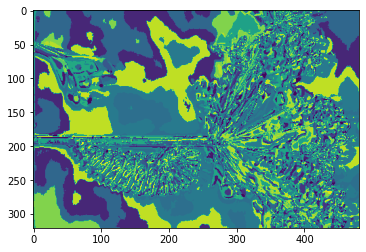

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1]
 [0 1 1 1 1 1 0]
 [0 0 1 1 1 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1]
 [0 0 0 0 1 1 1]
 [0 0 1 1 1 1 1]
 [0 1 1 1 1 1 0]
 [0 0 1 1 1 0 0]]
[[0 0 0 0 1 0 0]
 [0 0 0 0 1 1 0]
 [0 0 0 0 1 1 1]
 [0 0 0 0 1 1 1]
 [0 0 0 1 1 1 1]
 [0 0 0 1 1 1 0]
 [0 0 0 1 1 0 0]]
[[0 0 1 1 1 0 0]
 [0 0 1 1 1 1 0]
 [0 0 0 1 1 1 1]
 [0 0 0 0 1 1 1]
 [0 0 0 0 1 1 1]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0]]


In [143]:
num_bins = 64
Tg = get_Tg(gray,num_bins,half_disks)


(321, 481, 5)


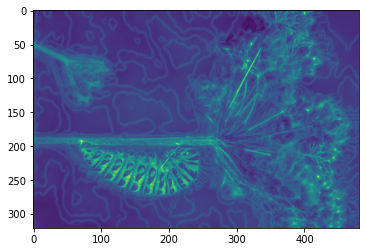

In [144]:
print(Tg.shape)
Tg1 = np.mean(Tg,axis=2)
plt.imshow(Tg1)
plt.savefig("Tg_2")
plt.show()

1. Generate Brightness Map
2. Perform brightness binning


In [129]:
def brightness_kmeans(img):
    p,q= np.shape(gray)
    inp = np.reshape(gray,((p*q),1))
    kmeans = KMeans(n_clusters = 16, random_state = 2)
    kmeans.fit(inp)
    labels = kmeans.predict(inp)
    l = np.reshape(labels,(p,q))
    # plt.imshow(l,cmap = 'binary')
    # plt.show()
    return l


1. Generate Brightness Gradient (Bg)
2. Perform Chi-square calculation on Brightness Map
3. Display Bg and save image as Bg_ImageName.png,
4. use command "cv2.imwrite(...)"



In [130]:
def get_Bg(img,num_bins,get_half_disks_arr):

    img_chi_tensor=img
    brightness_kmean = brightness_kmeans(img)
    for i in range(len(get_half_disks_arr)//2):
        left_mask = get_half_disks_arr[i]
        right_mask = get_half_disks_arr[i+len(get_half_disks_arr)//2]
        chi_sqr_dist = get_chisquare(img=brightness_kmean,num_bins=num_bins,left_mask=left_mask,right_mask=right_mask)
        img_chi_tensor = np.dstack((img_chi_tensor,chi_sqr_dist))
    img_chi_tensor[:,:,1:]
    return img_chi_tensor


In [131]:
Bg = get_Bg(gray,num_bins,half_disks)

(321, 481, 5)


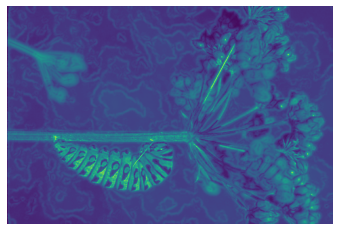

In [132]:
print(Bg.shape)
Bg1 = np.mean(Bg,axis=2)
plt.imshow(Bg1)
plt.axis("off")
plt.savefig("Bg_2")
plt.show()

1. Generate Color Map
2. Perform color binning or clustering


In [108]:
def color_kmeans(img):
    p,q = np.shape(gray)
    inp = np.reshape(gray,((p*q),1))
    kmeans = KMeans(n_clusters = 16, random_state = 2)
    kmeans.fit(inp)
    labels = kmeans.predict(inp)
    l = np.reshape(labels,(p,q))
    # plt.imshow(l)
    # plt.show()
    return l




1. Generate Color Gradient (Cg)
2. Perform Chi-square calculation on Color Map
3. Display Cg and save image as Cg_ImageName.png,
4. use command "cv2.imwrite(...)"



In [109]:
def get_Cg(img,num_bins,get_half_disks_arr):
    img_chi_tensor=img
    color_kmean = color_kmeans(img)
    for i in range(len(get_half_disks_arr)//2):
        left_mask = get_half_disks_arr[i]
        right_mask = get_half_disks_arr[i+len(get_half_disks_arr)//2]
        chi_sqr_dist = get_chisquare(img=color_kmean,num_bins=num_bins,left_mask=left_mask,right_mask=right_mask)
        img_chi_tensor = np.dstack((img_chi_tensor,chi_sqr_dist))
    img_chi_tensor[:,:,1:]
    return img_chi_tensor

In [111]:
Cg = get_Cg(image,num_bins,half_disks)

(321, 481, 7)


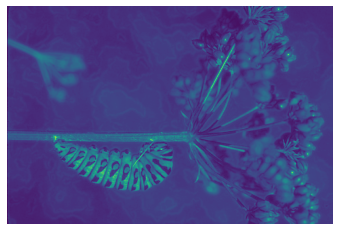

In [112]:
print(Cg.shape)
Cg1 = np.mean(Cg,axis=2)
plt.imshow(Cg1)
plt.axis("off")
plt.savefig("Cg_2")
plt.show()


1. Read Sobel Baseline
2. use command "cv2.imread(...)"


In [ ]:
# in cell 4




1. Read Canny Baseline
2. use command "cv2.imread(...)"



In [ ]:
# in cell 4



1. Combine responses to get pb-lite output
2. Display PbLite and save image as PbLite_ImageName.png
3. use command "cv2.imwrite(...)"



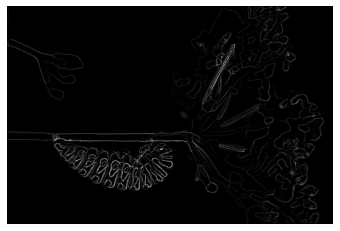

In [145]:
Tg = Tg[:,:,1:]
temp = (Tg1+Bg1+Cg1)/3
# mean = np.mean(temp,axis =2)
final = np.multiply(temp, (0.5*cannyBaseline+0.5*sobelBaseline))
plt.imshow(final ,cmap='gray')
plt.axis("off")
plt.savefig("PbLite.png")
plt.show()